# Sim-Real Data Experiment

In [1]:
import sys, os

sys.path.append("/home/emmanuel/code/isp_data")
sys.path.append("/home/emmanuel/code/gp_model_zoo/code/numpyro")

from jax.config import config
from jax import device_put
import jax.numpy as jnp

# from jax import random
# import numpy as np

# import chex
config.update("jax_enable_x64", False)

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.9)

%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
# ==========================
# INITIALIZE LOGGER
# ==========================
import wandb

wandb_logger = wandb.init(project="egp_1_1", entity="ipl_uv")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
wandb.config.exp = "simreal"
wandb.config.seed = 123

## Load Demo Data

In [4]:
from isp_data.simulation import uncertain

X, y = uncertain.load_prosail_training_df()

In [5]:
X.describe()

Band 1: Blue  Band 2: Green  Band 3: Red  Band 4: NIR  \
count   3303.000000    3303.000000  3303.000000  3303.000000   
mean       0.068743       0.105825     0.111666     0.362267   
std        0.046820       0.061809     0.079168     0.123083   
min        0.005332       0.006786     0.005533     0.033154   
25%        0.035533       0.060806     0.053779     0.273694   
50%        0.053992       0.089028     0.086402     0.363865   
75%        0.087720       0.134440     0.148359     0.448729   
max        0.279228       0.360767     0.437059     0.766682   

       Band 6: SWIR 1.6  Band 7: SWIR 2.1  
count       3303.000000       3303.000000  
mean           0.260562          0.173583  
std            0.092832          0.094373  
min            0.033389          0.009375  
25%            0.194152          0.104310  
50%            0.252580          0.152875  
75%            0.317240          0.225726  
max            0.569299          0.530368

In [6]:
y.describe()

LAI          FVC        FAPAR  CWC (g/cm2)  CCC (g/cm2)
count  3303.000000  3303.000000  3303.000000  3303.000000  3303.000000
mean      2.262788     0.592697     0.573906     0.040715     0.105892
std       1.853207     0.394076     0.356829     0.047395     0.100914
min       0.000015     0.000007     0.000010     0.000000     0.000000
25%       0.321631     0.157449     0.193685     0.004334     0.011619
50%       2.227418     0.691581     0.680800     0.027279     0.083860
75%       3.640792     0.929118     0.871570     0.058701     0.167256
max       7.764345     1.266707     1.137658     0.506256     0.539141

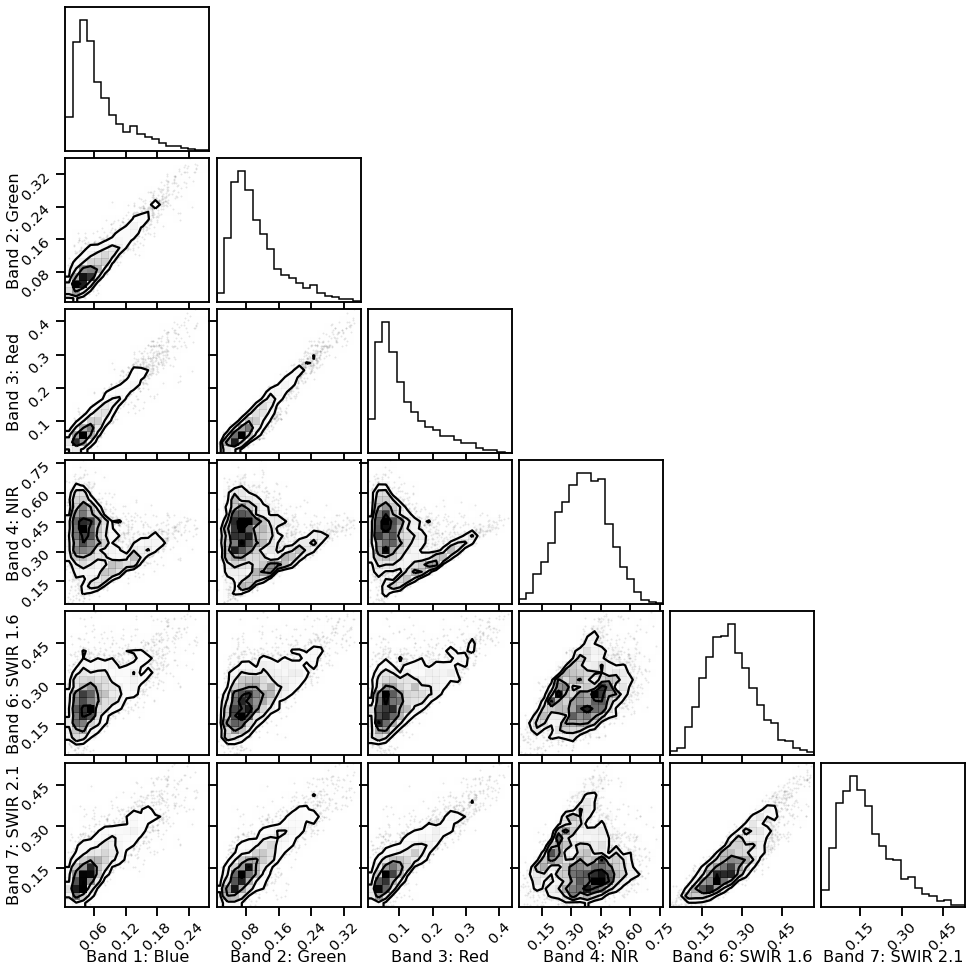

In [7]:
import corner

figure = corner.corner(X)
plt.gcf()
wandb.log({"sim_data_X": wandb.Image(plt)})

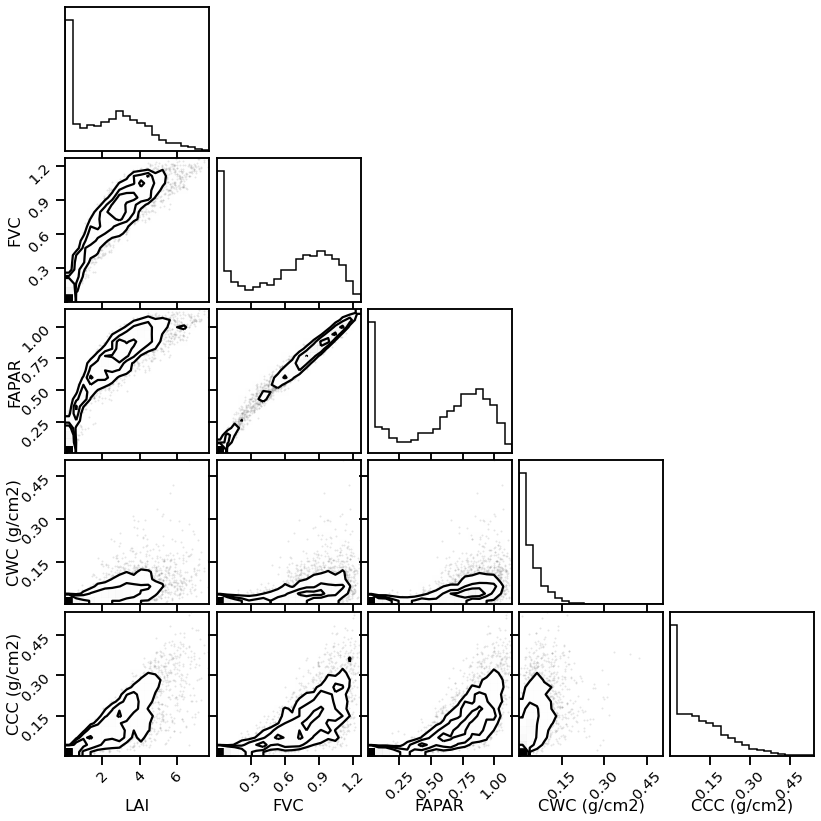

In [8]:
import corner

figure = corner.corner(y)
plt.gcf()
wandb.log({"sim_data_y": wandb.Image(plt)})

### Select Variable

In [9]:
y = y["LAI"]

### Train-Test Split

In [10]:
# from sklearn.model_selection import train_test_split

# random_state = 123
# train_size = 500

# Xtrain, Xtest, ytrain, ytest = train_test_split(
#     X, y.iloc[:, 0], train_size=train_size, random_state=random_state,
# )

### Standardization

In [11]:
from sklearn.preprocessing import StandardScaler

x_transformer = StandardScaler()

X_scaled = x_transformer.fit_transform(X)

y_transformer = StandardScaler(with_std=False)

y_scaled = y_transformer.fit_transform(y.values.reshape(-1, 1))

## GP Model

In [12]:
import chex
import jax
import jax.numpy as jnp
from chex import Array
from src.utils import identity_matrix, add_to_diagonal
from src.kernels import RBF

n_features = X_scaled.shape[1]

rbf_kernel = RBF(length_scale=jnp.ones(n_features), variance=1.0)
K = rbf_kernel.gram(X_scaled)

# check shape
chex.assert_shape(K, (X_scaled.shape[0], X_scaled.shape[0]))

model = "sparse"
wandb.config.model = model

#### Model

In [13]:
# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO
from src.utils import init_inducing_subsample, init_inducing_kmeans
from src.sparse import init_default_sgp_model
from src.exact import init_default_gp_model

jitter = 1e-5
inference = "map"

n_inducing = 100
n_length_scales = X_scaled.shape[1]
wandb.config.jitter = jitter

wandb.config.inference = inference
wandb.config.n_inducing = n_inducing
wandb.config.n_length_scales = n_length_scales

if model == "exact":

    numpyro_model = init_default_gp_model(
        n_features=n_length_scales, inference=inference, jitter=jitter
    )


elif model == "sparse":

    n_inducing = 100

    numpyro_model = init_default_sgp_model(
        X_scaled,
        n_features=n_length_scales,
        inference=inference,
        n_inducing=n_inducing,
        jitter=jitter,
    )


else:
    raise ValueError(f"Unrecognized model: {model}")


def empty_guide(X, y):
    pass

In [14]:
# NUMPYRO SETTINGS
with numpyro.handlers.seed(rng_seed=123):
    t = numpyro_model(X_scaled, y_scaled)

assert t.shape == y_scaled.shape

#### Inference

In [15]:
from numpyro.infer.autoguide import (
    AutoDelta,
    AutoMultivariateNormal,
    AutoDiagonalNormal,
)

# ===================
# Model
# ===================
# GP model

# delta guide - basically deterministic


if inference == "map":
    guide = AutoDelta(numpyro_model)
elif inference == "vi_mf":
    guide = AutoDiagonalNormal(numpyro_model)
elif inference == "vi_full":
    guide = AutoMultivariateNormal(numpyro_model)
elif inference == "mll":

    def empty_guide(X, y):
        pass

    guide = empty_guide
else:
    raise ValueError(f"Unrecognized inference scheme: {inference}")

#### Training

In [16]:
# reproducibility
rng_key = jax.random.PRNGKey(0)

# Setup
wandb.config.step_size = 0.01
wandb.config.train_seed = 42
wandb.config.iterations = 2_500


# Setup
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(numpyro_model, guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(1), 2_500, X_scaled, y_scaled.T)

100%|██████████| 2500/2500 [01:00<00:00, 41.36it/s, init loss: 6679.5601, avg. loss [2376-2500]: 3846.2095]


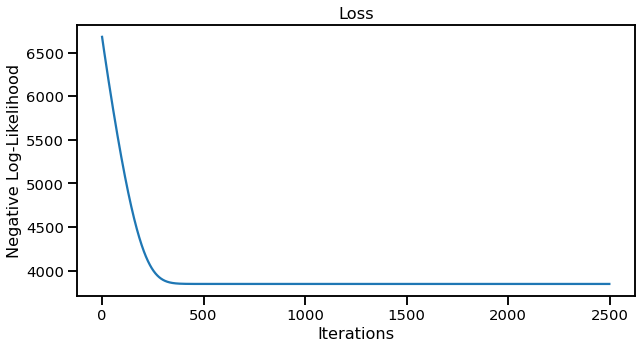

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(svi_results.losses)
ax.set(title="Loss", xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.gcf()
wandb.log({"loss": wandb.Image(plt)})

#### Extract Params

In [18]:
from pprint import pprint

# Take them directly
learned_params = svi_results.params
# pprint(learned_params)

if inference != "mll":
    if model == "sparse":
        x_u = learned_params["x_u"]
        learned_params = guide.median(learned_params)
        learned_params["x_u"] = x_u
    elif model == "exact":
        learned_params = guide.median(learned_params)
    else:
        raise ValueError(f"Unrecognized model: {model}")


# pprint(learned_params)

## Predictions

In [19]:
if model == "sparse":
    from src.sparse import init_sgp_predictive

    gp_pred = init_sgp_predictive(RBF, learned_params, X_scaled, y_scaled, jitter=1e-5)
elif model == "exact":
    from src.exact import init_gp_predictive

    gp_pred = init_gp_predictive(RBF, learned_params, X_scaled, y_scaled, jitter=0.0)
else:
    raise ValueError(f"Unrecognized model: {model}")


mu = gp_pred.predict_mean(jnp.array(X_scaled))

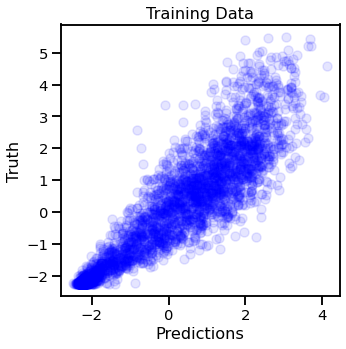

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(mu, y_scaled, alpha=0.1, c="blue")
ax.set(xlabel="Predictions", ylabel="Truth", title="Training Data")

plt.gcf()
wandb.log({"gp_pred_sim": wandb.Image(plt)})

### Statistics

In [21]:
from uncertainty_toolbox import get_all_metrics

In [22]:
mu, var = gp_pred.predict_y(X_scaled)

std = jnp.sqrt(var.squeeze())

In [23]:
import numpy as np
import pandas as pd

metrics = get_all_metrics(
    y_pred=np.array(mu).ravel(),
    y_std=np.array(std).ravel(),
    y_true=np.array(y_scaled).ravel(),
)

wandb.log(metrics)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:01,  8.48it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|█         | 1/10 [00:00<00:01,  8.03it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.50it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.514
  RMSE          0.746
  MDAE          0.330
  MARPD         54.387
  R2            0.838
  Correlation   0.915
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.116
  Mean-absolute Calibration Error       0.097
  Miscalibration Area                   0.098
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.119
     Group Size: 0.56 -- Calibration Error: 0.103
     Group Size: 1.00 -- Calibration Error: 0.097
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.141
     Group Size: 0.56 -- Calibration Error: 0.123
     Group Size: 1.00 -- Calibration Error: 0.116
===============

#### Plots

In [24]:
from uncertainty_toolbox import viz as utviz


def plot_all_uncertainty(y_pred, y_std, y_true, data):

    utviz.plot_parity(y_pred=y_pred.ravel(), y_true=y_true.ravel())
    plt.gcf()
    wandb.log({f"parity_{data}": wandb.Image(plt)})

    utviz.plot_calibration(
        y_pred=y_pred.ravel(), y_std=y_std.ravel(), y_true=y_true.ravel()
    )
    plt.gcf()
    wandb.log({f"calib_{data}": wandb.Image(plt)})

    utviz.plot_intervals_ordered(
        y_pred=y_pred.ravel(), y_std=y_std.ravel(), y_true=y_true.ravel(), n_subset=100
    )
    plt.gcf()
    wandb.log({f"intervals_{data}": wandb.Image(plt)})

    utviz.plot_sharpness(y_std=y_std.ravel(),)
    plt.gcf()
    wandb.log({f"sharpness_{data}": wandb.Image(plt)})

    utviz.plot_adversarial_group_calibration(
        y_pred=y_pred.ravel(), y_std=y_std.ravel(), y_true=y_true.ravel(), n_subset=100
    )
    plt.gcf()
    wandb.log({f"adverse_{data}": wandb.Image(plt)})

### 

Lims is None. Setting lims now:
min_max_true: (-2.2627726071737775, 5.501556836221223)
min_max_pred: (DeviceArray(-2.4749188, dtype=float32), DeviceArray(4.123655, dtype=float32))
lims: (-2.474918842315674, 5.501556836221223)
lims_ext: (-3.2725664101693637, 6.299204404074913)


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


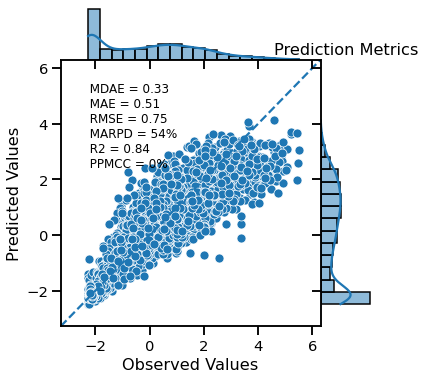

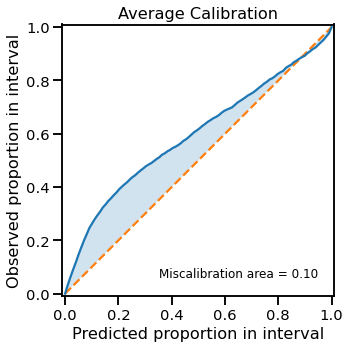

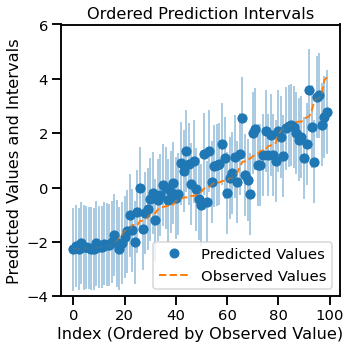

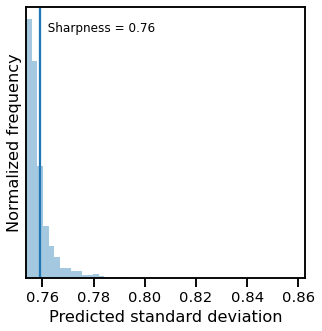

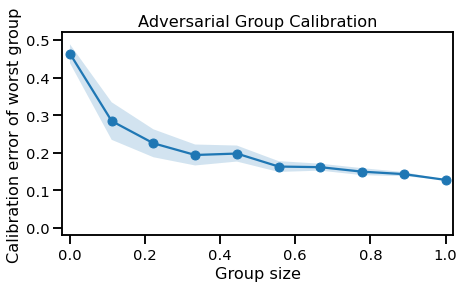

In [25]:
plot_all_uncertainty(mu, std, y_scaled, "sim")

## Test Data

In [26]:
ds_real = uncertain.load_histarfm_testing_df()

# drop nans
ds_real = ds_real.dropna()

# parse
Xreal_mu, Xreal_std, Y_real = uncertain.parse_histarfm_ds(ds_real)
Xreal_mu.columns = X.columns
Xreal_std.columns = X.columns

/home/emmanuel/code/isp_data/isp_data/simulation/uncertain.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Lai_mean"] = Y["Lai_mean"].apply(transform_histarfm_lai)
/home/emmanuel/code/isp_data/isp_data/simulation/uncertain.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y["Fpar_mean"] = Y["Fpar_mean"].apply(transform_histarfm_fapar)


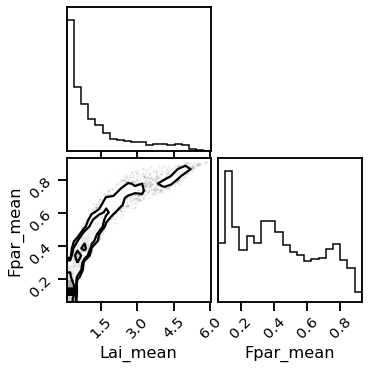

In [27]:
figure = corner.corner(Y_real)

In [28]:
Y_real.describe()

Lai_mean    Fpar_mean
count  3320.000000  3320.000000
mean      1.287666     0.424059
std       1.320577     0.236908
min       0.100000     0.060000
25%       0.299295     0.210505
50%       0.754397     0.392066
75%       1.761429     0.620908
max       6.007066     0.929591

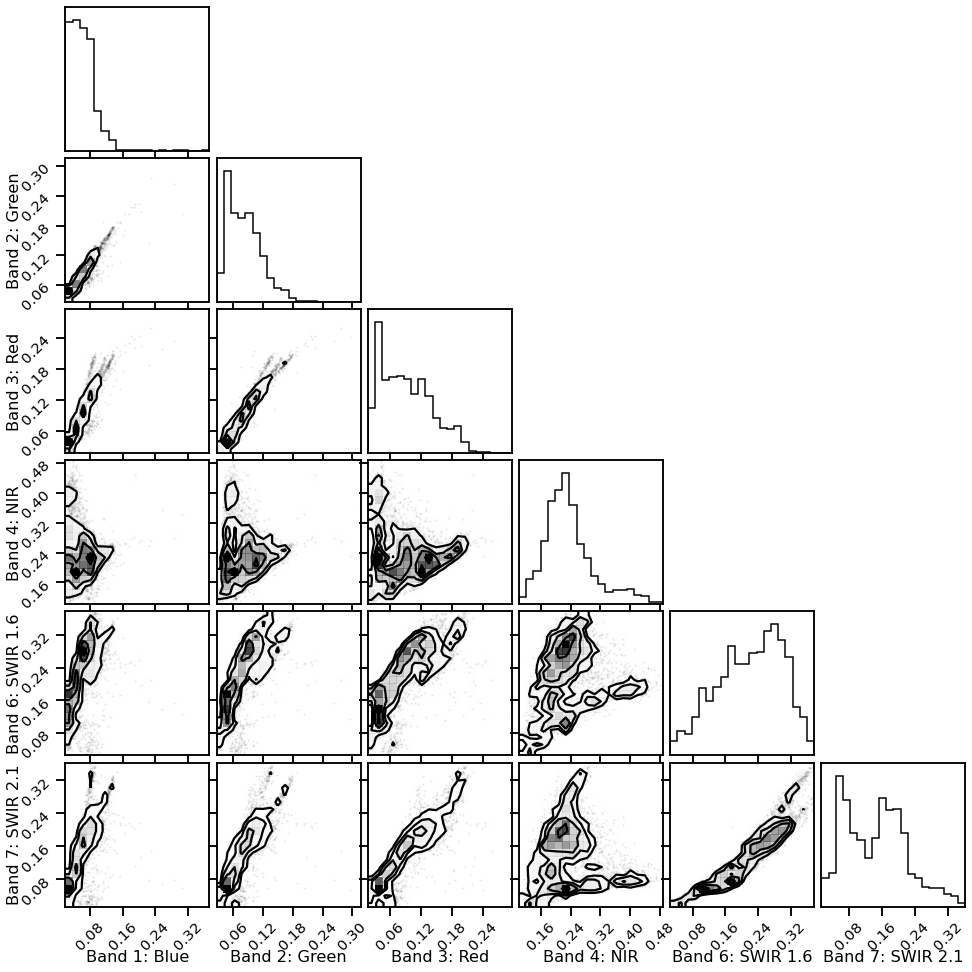

In [29]:
# Xtrain_scaled
figure = corner.corner(Xreal_mu, hist_factor=2)
plt.gcf()
wandb.log({"real_data_X": wandb.Image(plt)})

### Transforms

In [30]:
Xreal_mu_scaled = x_transformer.transform(Xreal_mu)
# Xreal_std_scaled = x_transformer.transform(Xreal_std)

Y_real_scaled = y_transformer.transform(Y_real["Lai_mean"].values.reshape(-1, 1))

In [31]:
mu_real = gp_pred.predict_mean(jnp.array(Xreal_mu_scaled))

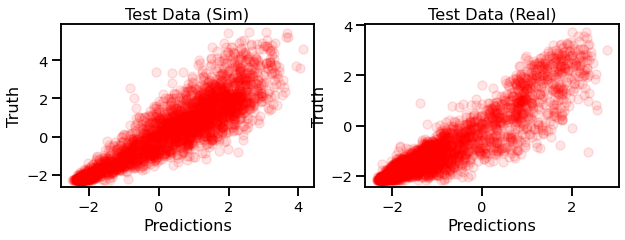

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))

ax[0].scatter(mu, y_scaled, alpha=0.1, c="red")
ax[0].set(xlabel="Predictions", ylabel="Truth", title="Test Data (Sim)")

ax[1].scatter(mu_real, Y_real_scaled, alpha=0.1, c="red")
ax[1].set(xlabel="Predictions", ylabel="Truth", title="Test Data (Real)")
plt.gcf()
wandb.log({"gp_pred_real": wandb.Image(plt)})

In [33]:
mu_real, var_real = gp_pred.predict_y(jnp.array(Xreal_mu_scaled))

std_real = jnp.sqrt(var_real.squeeze())

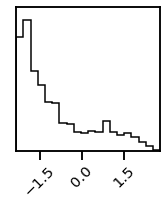

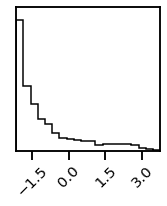

In [34]:
figure = corner.corner(mu_real)
figure = corner.corner(Y_real_scaled)

#### Statistics

In [35]:
import numpy as np
import pandas as pd

metrics = get_all_metrics(
    y_pred=np.array(mu_real).ravel(),
    y_std=np.array(std_real).ravel(),
    y_true=np.array(Y_real_scaled).ravel(),
)

wandb.log(metrics)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 10%|█         | 1/10 [00:00<00:01,  8.09it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 10%|█         | 1/10 [00:00<00:01,  8.46it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  5.60it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.344
  RMSE          0.509
  MDAE          0.193
  MARPD         37.483
  R2            0.852
  Correlation   0.923
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.220
  Mean-absolute Calibration Error       0.194
  Miscalibration Area                   0.196
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.211
     Group Size: 0.56 -- Calibration Error: 0.200
     Group Size: 1.00 -- Calibration Error: 0.194
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.241
     Group Size: 0.56 -- Calibration Error: 0.227
     Group Size: 1.00 -- Calibration Error: 0.220
===============

#### Plots

In [36]:
mu_real.shape, std_real.shape, Y_real_scaled.shape, y_scaled.shape

((3320, 1), (3320,), (3320, 1), (3303, 1))

Lims is None. Setting lims now:
min_max_true: (-2.162787863778777, 3.7442777967495204)
min_max_pred: (DeviceArray(-2.345226, dtype=float32), DeviceArray(2.79317, dtype=float32))
lims: (-2.3452260494232178, 3.7442777967495204)
lims_ext: (-2.9541764340404915, 4.353228181366794)


/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


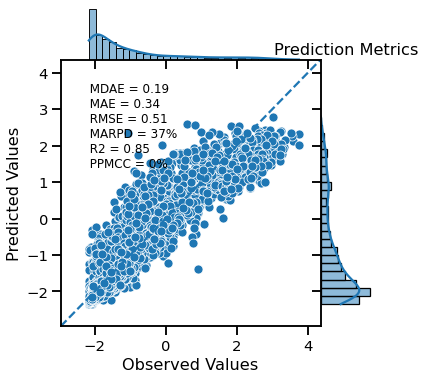

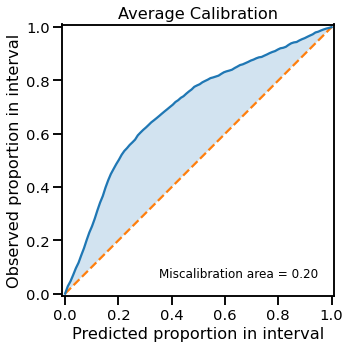

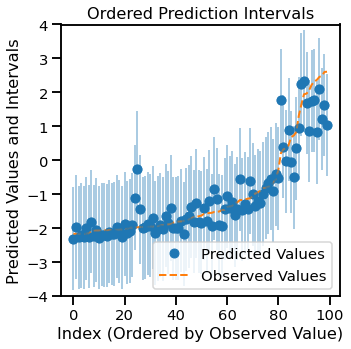

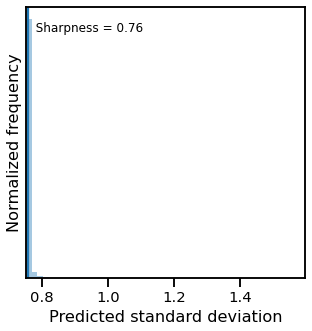

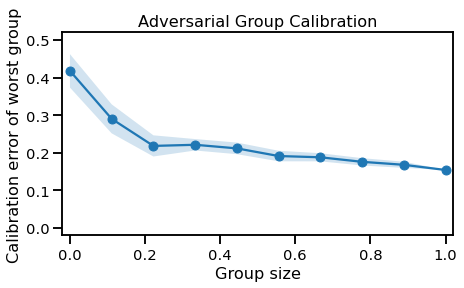

In [37]:
plot_all_uncertainty(mu_real, std_real, Y_real_scaled, "real")

## Demo Map Data

In [38]:
import rasterio
from rasterio import plot as rasterioplt
from pathlib import Path

* `ExportLandsatData_crops_6_v1.tif`
* `ExportLandsatData_albur_6_v1.tif`
* ``

In [39]:
image_dir = Path(
    "/media/disk/databases/PROSAIL/Landsat_validation_areas/Validation_Emman"
)
img_type = "lolo"  # crops, albur, lolo
month = 6
image_filename = Path(f"ExportLandsatData_{img_type}_{month}_v1.tif")

#### Demo Image

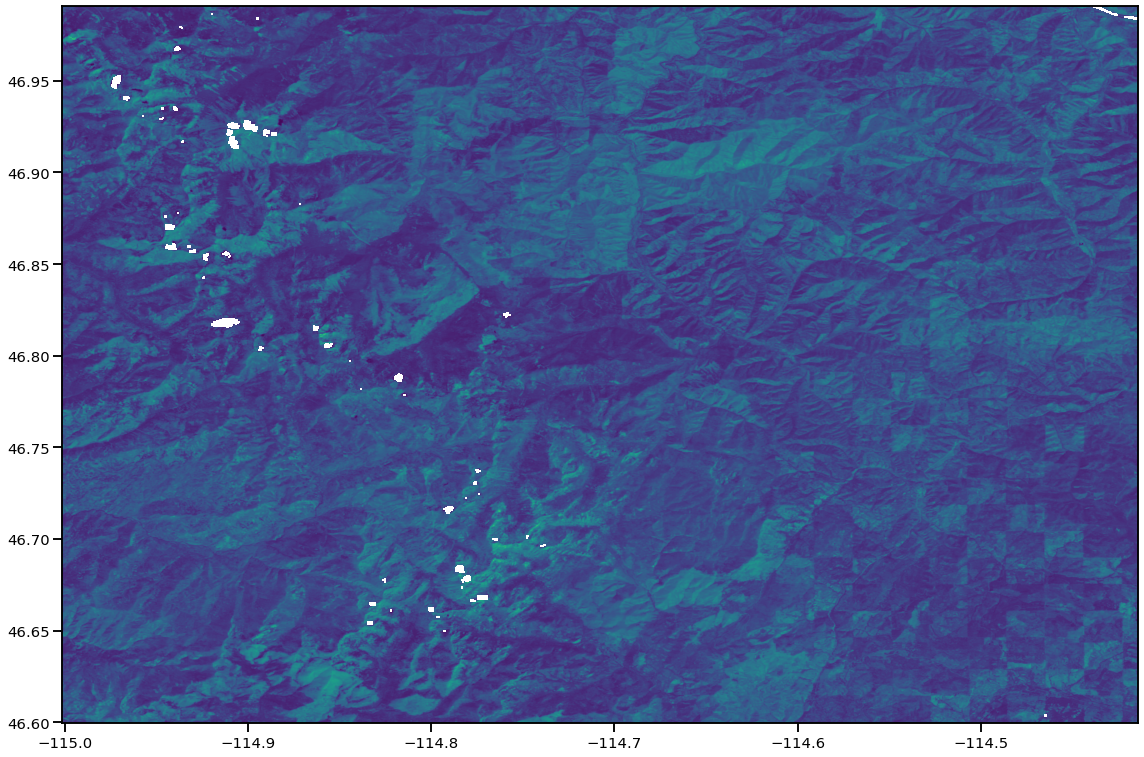

In [40]:
with rasterio.open(image_dir.joinpath(image_filename), "r") as f:
    img_transform = f.transform
    img_shape = f.shape
    img_mu = f.read()[:6]
    img_std = f.read()[6:]
    fig, ax = plt.subplots(figsize=(16, 16))
    rasterioplt.show(f.read(5), transform=f.transform, ax=ax)
    plt.tight_layout()
    plt.gcf()
    wandb.log({f"landsat_image_{img_type}_{month}": wandb.Image(plt)})

### Predictions

In [41]:
def transform_batches(X):

    # transform to landsat coordinates
    X = uncertain.transform_histarfm_bands_mu(X)

    # rescale data
    X = x_transformer.transform(X)

    return X

In [42]:
from einops import rearrange
import tqdm

In [43]:
img_vec_mu = rearrange(img_mu, "C H W -> (H W) C")

# transform data
img_vec_mu = transform_batches(img_vec_mu)

In [44]:
# remove NANs (2D Array)
img_vec_mu_notnan = img_vec_mu[~np.isnan(img_vec_mu).any(axis=1), :]

In [45]:
# # Xtrain_scaled
# img_vec_mu_notnan = img_vec_mu[~np.isnan(img_vec_mu).any(axis=1), :]
# figure = corner.corner(img_vec_mu_notnan)
# plt.gcf()
# wandb.log({"landsat_demo_data": wandb.Image(plt)})

This is quite a large image and way too big for a single GP prediction. So we're going to predict things in batches. 

In [46]:
batch_size = 5_000
n_batches = max(int(img_vec_mu.shape[0] / batch_size), 1)

mu_image_vec, std_image_vec = [], []
with tqdm.tqdm(np.array_split(img_vec_mu, n_batches)) as pbar:
    for X_batch in pbar:

        mu_, var_ = gp_pred.predict_f(X_batch)
        mu_image_vec.append(mu_)
        std_image_vec.append(np.sqrt(var_))

# concatenate
mu_image_vec = np.concatenate(mu_image_vec, axis=0)
std_image_vec = np.concatenate(std_image_vec, axis=0)

100%|██████████| 632/632 [00:14<00:00, 44.12it/s]


In [47]:
mu_image = rearrange(
    mu_image_vec, "(H W) C-> H W C", H=img_shape[0], W=img_shape[1], C=1
)
std_image = rearrange(
    std_image_vec, "(H W) C-> H W C", H=img_shape[0], W=img_shape[1], C=1
)

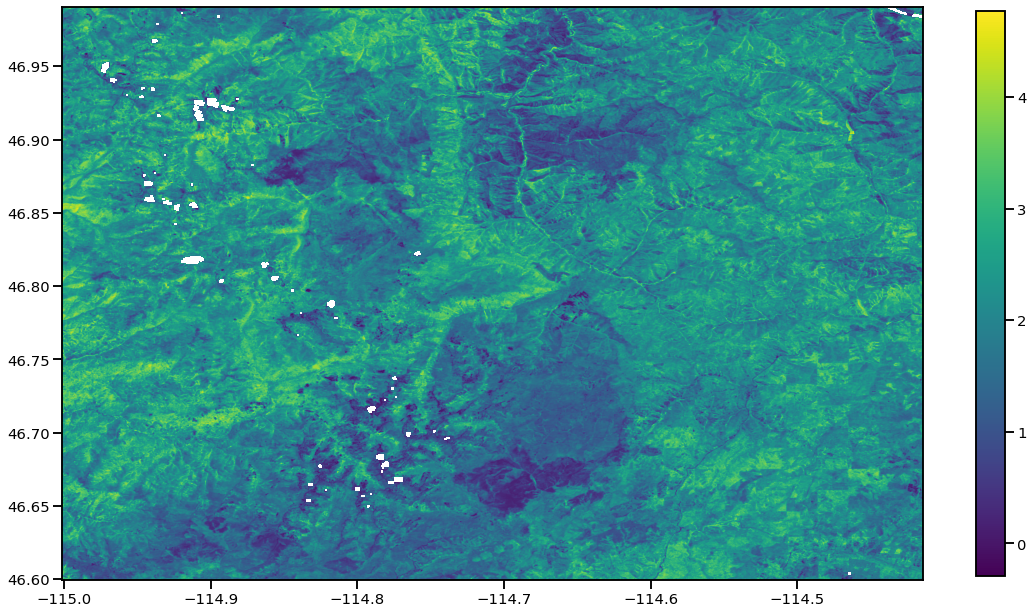

In [48]:
fig, ax = plt.subplots(figsize=(16, 16))
temp = y_transformer.inverse_transform(mu_image)
image_hidden = plt.imshow(temp)
image_fig = rasterioplt.show(temp, transform=f.transform, ax=ax)
plt.colorbar(image_hidden, ax=ax, shrink=0.5)
plt.tight_layout()
plt.gcf()
wandb.log({f"landsat_pred_mu_{img_type}_{month}": wandb.Image(plt)})

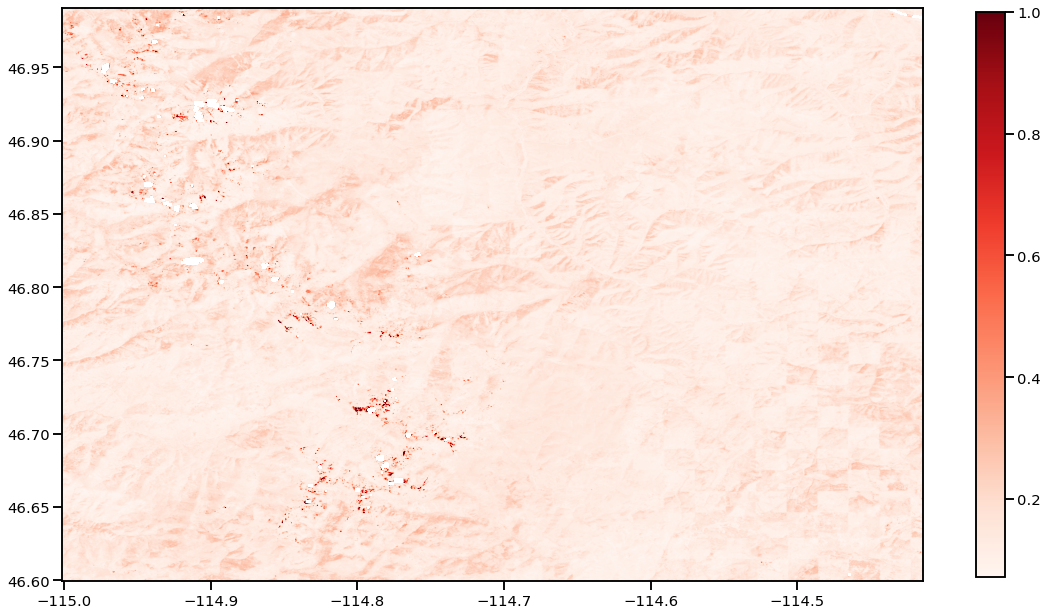

In [49]:
fig, ax = plt.subplots(figsize=(16, 16))
image_hidden = plt.imshow(1.96 * std_image, vmax=1.0, cmap="Reds")
image_fig = rasterioplt.show(
    1.96 * std_image, transform=f.transform, ax=ax, vmax=1.0, cmap="Reds"
)
plt.colorbar(
    image_hidden, ax=ax, shrink=0.5,
)
plt.tight_layout()
plt.gcf()
wandb.log({f"landsat_pred_std_{img_type}_{month}": wandb.Image(plt)})